## 2 Data

In [2]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import wrds
db=wrds.Connection(wrds_username='sahakyan')

C:\Users\edoul\AppData\Local\Temp\ipykernel_22544\1496301343.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [21]:
#---------------------------------------------
# Risk Free Rate 
#---------------------------------------------
Rf=db.raw_sql("""select  mcaldt,tmytm 
           from crsp.tfz_mth_rf            
            where kytreasnox = 2000001 
           and mcaldt>='1964-01-01'
            and mcaldt<='2023-12-31'""", date_cols=['mcaldt'])
Rf['tmytm']=Rf['tmytm']/12/100
Rf=Rf.rename(columns={ "mcaldt": "date","tmytm": "rf"})


#---------------------------------------------
# Value Weighted Index Returns
#---------------------------------------------
Rm=db.raw_sql("""select  date,vwretd from crsp.msi 
                where date>='1964-01-01' and date<='2023-12-31'
                """,date_cols=['date'])
Rm = Rm.rename(columns={'vwretd':'Rm'})

#---------------------------------------------
# Stock Returns 
#---------------------------------------------
stock_data = db.raw_sql("""
                    select a.permno, a.date, 
                      b.shrcd, b.exchcd,
                      a.ret, a.shrout, a.prc
                      from crsp.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/01/1964' and '12/31/2023'
                      and b.exchcd between 1 and 2
                      and b.shrcd between 10 and 11
                      """, date_cols=['date']) 
stock_data=stock_data.drop(['shrcd','exchcd'],axis=1)
stock_data = stock_data.rename(columns={'ret':'Rn'})
stock_data['mcap'] = np.abs(stock_data['prc'])*stock_data['shrout']
stock_data['mcap_l'] = stock_data.groupby(['permno'])['mcap'].shift(1)


#---------------------------------------------
# Merge Data 
#---------------------------------------------
data = pd.merge(stock_data, Rf, on=['date'], how='left')
data = pd.merge(data, Rm, on=['date'], how='left')
data['const'] = 1
data['Rn_e'] = data['Rn']-data['rf']
data['Rm_e'] = data['Rm']-data['rf']
data = data.sort_values(by=['permno', 'date'])
data.to_csv('data.csv', sep=';',index=False) # export data


## 3 Betting against Beta strategy (BaB)

#### (a) Computation of time-varying Beta

In [23]:
# (a)
# 0. Remove nans
data = data.dropna(subset=['mcap_l','Rn_e','Rm_e']).copy()

# 2. Estimate Rolling Betas
cov_nm = data.set_index('date').groupby('permno')[['Rn_e','Rm_e']].rolling(window = 60, min_periods=36).cov()
beta_n = (cov_nm.iloc[0::2,1].droplevel(2)/cov_nm.iloc[1::2,1].droplevel(2))
beta_n = beta_n.dropna().reset_index().rename(columns={'Rm_e':'beta'})

# 3. Merge betas with data
beta_n['date'] = beta_n['date'] + pd.DateOffset(months=1)
data = data.merge(beta_n, on=['permno','date'], how='left')

# get rid of nan values
data = data.dropna(subset=['beta']).copy()

# 4. Remove outliers
data['beta'] = data['beta'].clip(data['beta'].quantile(0.05),data['beta'].quantile(0.95))


In [24]:
#count beta not nan
print(data['beta'].count())

len(data['beta'])

403316


403316

#### (B) Beta Deciles

36         2.539616e+09
37         2.576220e+09
38         2.713726e+09
44         2.715997e+09
48         2.521190e+09
               ...     
1420778    1.590868e+09
1420780    1.423976e+09
1420784    1.560010e+09
1420786    1.578670e+09
1420789    1.734676e+09
Name: mcap, Length: 403316, dtype: float64
403316
403316


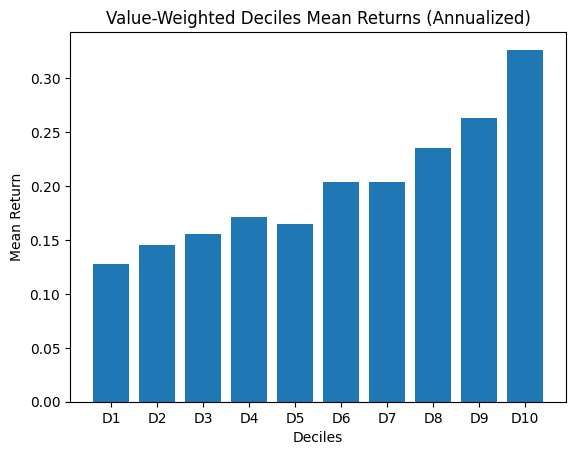

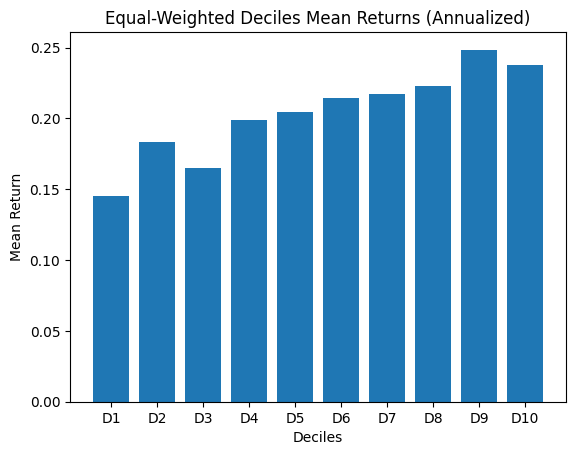

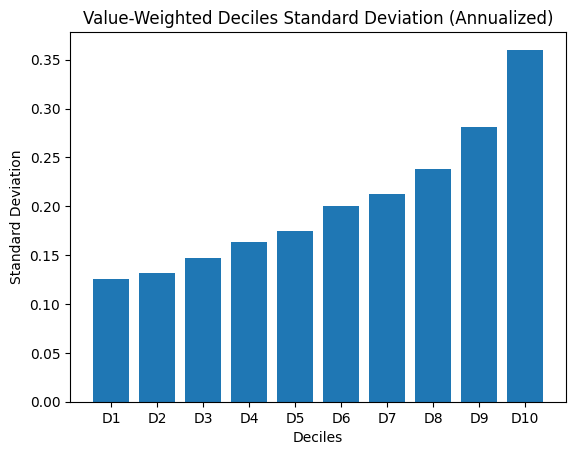

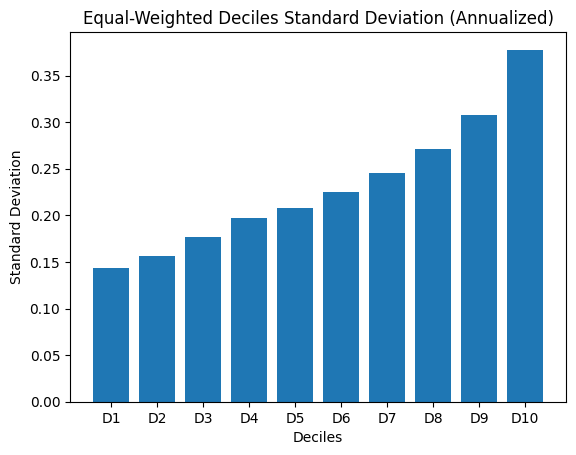

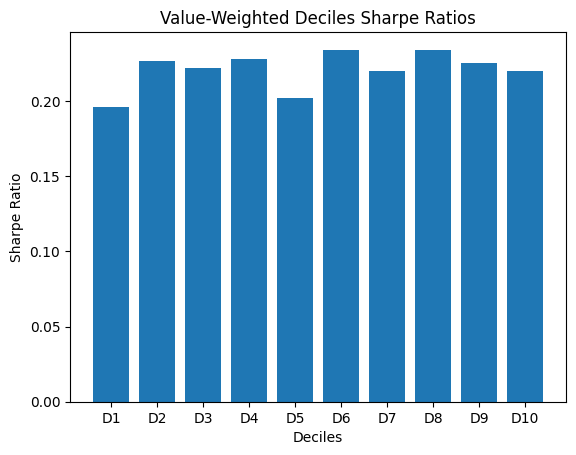

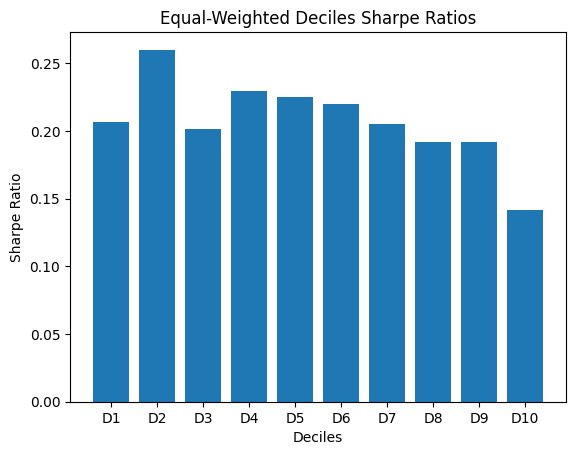

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'data' is a DataFrame with columns: 'date', 'beta', 'mcap', and 'Rn'
# (b)
# 1. Deciles
data['beta_Q'] = data.groupby('date')['beta'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))
# 2. Market Weights within deciles
data['vw_Q'] = data['mcap'] / data.groupby(['date', 'beta_Q'])['mcap'].transform('sum')
print(data.groupby(['date', 'beta_Q'])['mcap'].transform('sum'))
print(len(data['vw_Q']))
print(len(data['mcap']))
# 3. VW Portfolios
data['beta_ret_vw'] = data['vw_Q'] * data['Rn']
ret_vw = data.groupby(['date', 'beta_Q'])['beta_ret_vw'].sum().reset_index()
vw_ret_mean = ret_vw.groupby('beta_Q')['beta_ret_vw'].mean()

# 4. Equal-Weighted portfolios
ret_ew = data.groupby(['date', 'beta_Q'])['Rn'].mean().reset_index()
ew_ret_mean = ret_ew.groupby('beta_Q')['Rn'].mean()

# Calculate standard deviations
vw_ret_std = ret_vw.groupby('beta_Q')['beta_ret_vw'].std()
ew_ret_std = ret_ew.groupby('beta_Q')['Rn'].std()

# Compute the Sharpe Ratios for each decile

# compute the risk-free rate
rf = data.groupby(['date', 'beta_Q'])['rf'].mean().reset_index()

# compute the excess returns
ret_vw['excess'] = ret_vw['beta_ret_vw'] - rf['rf']
ret_ew['excess'] = ret_ew['Rn'] - rf['rf']

# compute the Sharpe Ratios
vw_sharpe = ret_vw.groupby('beta_Q')['excess'].mean() / ret_vw.groupby('beta_Q')['beta_ret_vw'].std()
ew_sharpe = ret_ew.groupby('beta_Q')['excess'].mean() / ret_ew.groupby('beta_Q')['Rn'].std()


# 5. Plot Histograms
deciles = ['D' + str(x) for x in np.arange(1, 11)]

#save plots
# Plot VW mean returns
plt.bar(deciles, vw_ret_mean * 12)
plt.title('Value-Weighted Deciles Mean Returns (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Mean Return')
plt.savefig('vw_ret_mean.png')
plt.show()

# Plot EW mean returns
plt.bar(deciles, ew_ret_mean * 12)
plt.title('Equal-Weighted Deciles Mean Returns (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Mean Return')
plt.savefig('ew_ret_mean.png')
plt.show()

# Plot VW standard deviations
plt.bar(deciles, vw_ret_std * np.sqrt(12))
plt.title('Value-Weighted Deciles Standard Deviation (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Standard Deviation')
plt.savefig('vw_ret_std.png')
plt.show()

# Plot EW standard deviations
plt.bar(deciles, ew_ret_std * np.sqrt(12))
plt.title('Equal-Weighted Deciles Standard Deviation (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Standard Deviation')
plt.savefig('ew_ret_std.png')
plt.show()

# Plot VW Sharpe Ratios
plt.bar(deciles, vw_sharpe)
plt.title('Value-Weighted Deciles Sharpe Ratios')
plt.xlabel('Deciles')
plt.ylabel('Sharpe Ratio')
plt.savefig('vw_sharpe.png')
plt.show()

# Plot EW Sharpe Ratios
plt.bar(deciles, ew_sharpe)
plt.title('Equal-Weighted Deciles Sharpe Ratios')
plt.xlabel('Deciles')
plt.ylabel('Sharpe Ratio')
plt.savefig('ew_sharpe.png')
plt.show()





TODO
- Question: Summarize our findings. Is the evidence consistent with the CAPM?
- Answer:

#### (c/d) Construct BAB factor

In [12]:
# Weights
data['z'] = data.groupby('date')['beta'].transform(lambda x: x.rank())
data['z_'] = data['z']-data.groupby('date')['z'].transform('mean')
data['k'] = np.abs(data['z_'])
data['k'] = 2/data.groupby('date')['k'].transform('sum')
data['w_H'] = data['k'] * data['z_'] * (data['z_']>0) 
data['w_L'] = -data['k'] * data['z_'] * (data['z_']<0) 

# Weighted returns and beta
data['beta_H'] = data['w_H'] * data['beta']
data['beta_L'] = data['w_L'] * data['beta']
data['R_H'] = data['w_H'] * data['Rn']
data['R_L'] = data['w_L'] * data['Rn']
data['R_H_e'] = data['w_H'] * data['Rn_e']
data['R_L_e'] = data['w_L'] * data['Rn_e']

BAB = data.groupby('date')[['R_H','R_L','R_H_e','R_L_e','beta_H','beta_L']].sum().reset_index()
# Levered and unlevered returns
BAB['BAB1'] = BAB['R_L'] - BAB['R_H']
BAB['BAB2'] = (BAB['R_L_e']/BAB['beta_L']) - ( BAB['R_H_e']/BAB['beta_H'] )


In [13]:
BAB.head()

,date,R_H,R_L,R_H_e,R_L_e,beta_H,beta_L,BAB1,BAB2
0,1928-01-31,0.019097,-0.006957,0.015767,-0.010286,1.522616,0.497003,-0.026054,-0.031052
1,1928-02-29,-0.016198,-0.023230,-0.019025,-0.026056,1.538988,0.515339,-0.007031,-0.038199
2,1928-03-31,0.109825,0.106972,0.107019,0.104166,1.480198,0.498755,-0.002853,0.136551
3,1928-04-30,0.060100,0.075325,0.056933,0.072158,1.484202,0.518877,0.015224,0.100705
4,1928-05-31,0.014240,0.031413,0.011000,0.028173,1.480773,0.517211,0.017173,0.047042


In [14]:
# Merge Market and Risk free Rate
tmp = pd.merge(BAB,data[['date','Rm_e']].drop_duplicates(), on=['date'], how='left')
tmp['alpha'] = 1

# Alpha and Beta
import statsmodels.api as sm
tmp = tmp.dropna()
OLS_Reg = sm.OLS(tmp['BAB2'], tmp[['alpha','Rm_e']]).fit()

# Report the mean,standard deviation, and sharpe ratio and CAPM alpha of the BAB factor
print('Mean:', tmp['BAB2'].mean())
print('Standard Deviation:', tmp['BAB2'].std())
# Annualize the Sharpe ratio and CAPM alpha
print('Sharpe ratio:', tmp['BAB2'].mean()/tmp['BAB2'].std()*np.sqrt(12))
print('Monthly CAPM Alpha:', OLS_Reg.params['alpha']*12)



Mean: 0.006055773686068576
Std: 0.039195098182527414
Sharpe ratio: 0.5352152789394072
Monthly CAPM Alpha: 0.07240809284214449
